In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option('mode.chained_assignment',None)

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2

In [3]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[5:12])
df_full.head()

,time,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,2019-10-31 00:00:11,86,0,1.000000,0.000800,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
1,2019-10-31 00:01:04,84,0,0.999989,0.004654,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
2,2019-10-31 00:01:14,99,0,0.999986,0.005381,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
3,2019-10-31 00:02:06,52,0,0.999958,0.009163,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,0,0
4,2019-10-31 00:03:33,47,0,0.999880,0.015489,6.0,3.4,0.0,0.0,1027.7,...,0,0,0,0,0,0,0,0,1,0


## Simple network

In [105]:
df = df_full.drop(columns=['hour_index', 'dist_to_station', 'degree']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df.drop(columns = ['index'], inplace=True)

In [106]:
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.38,1,0.999999,0.001309,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.38,1,0.999994,0.003418,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.32,1,0.999984,0.005600,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.65,1,0.999982,0.006036,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.38,1,0.999950,0.010035,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155841,0.50,0,0.990258,-0.139245,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
155842,0.80,0,0.990629,-0.136580,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155843,0.90,0,0.990797,-0.135355,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [107]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [108]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(264,32),
            nn.ReLU(inplace = True),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(inplace = True),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        #self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=264, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
) 9025


Epoch  1: Train Loss 0.194237 , Valid Loss -0.108644 ,Train R2 0.105967, Valid R2 0.108741
Epoch 11: Train Loss -0.213627 , Valid Loss -0.208737 ,Train R2 0.217660, Valid R2 0.209763
Epoch 21: Train Loss -0.220627 , Valid Loss -0.210707 ,Train R2 0.224648, Valid R2 0.211764
Epoch 31: Train Loss -0.228580 , Valid Loss -0.213343 ,Train R2 0.232964, Valid R2 0.214494
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss -0.234832 , Valid Loss -0.213002 ,Train R2 0.239219, Valid R2 0.214269
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 43: Train Loss -0.235828 , Valid Loss -0.212826 , Train R2 0.240186, Valid R2 0.214133


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

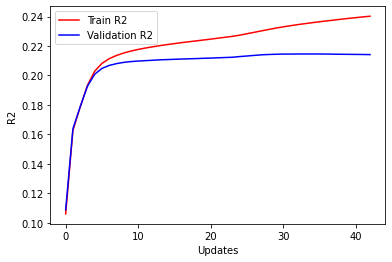

In [109]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

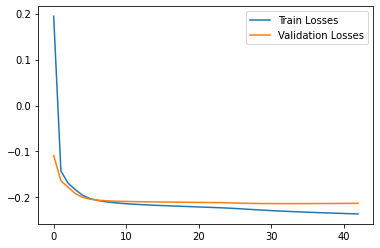

Max Val R2: 0.2145681475724721
Test R2: 0.21037703701540833


In [110]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

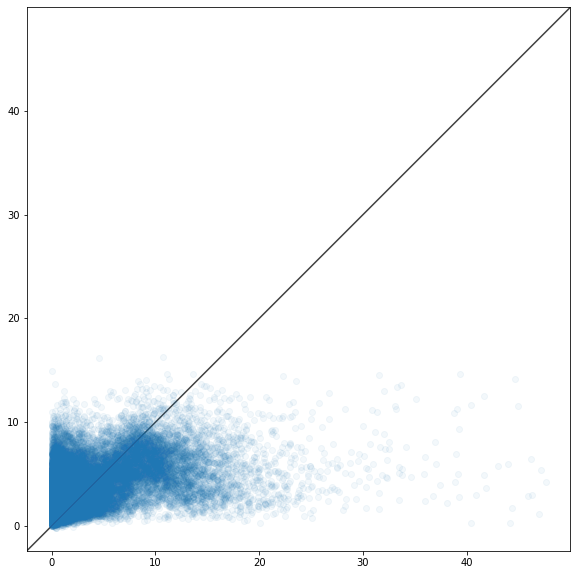

In [111]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## No Zones

In [18]:
df = df_full.iloc[:,:11]
df.drop(columns = ['degree','index','hour_index'], inplace = True)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.38,1,0.999999,0.001309,0,0,1,0
1,0.38,1,0.999994,0.003418,1,0,0,0
2,0.32,1,0.999984,0.005600,0,1,0,0
3,0.65,1,0.999982,0.006036,0,0,1,0
4,0.38,1,0.999950,0.010035,0,0,1,0
...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0
155841,0.50,0,0.990258,-0.139245,0,0,1,0
155842,0.80,0,0.990629,-0.136580,0,0,1,0
155843,0.90,0,0.990797,-0.135355,0,0,1,0


In [19]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 833


Epoch  1: Train Loss 0.071462 , Valid Loss -0.088151 ,Train R2 0.083597, Valid R2 0.087890
Epoch 11: Train Loss -0.097932 , Valid Loss -0.103773 ,Train R2 0.098368, Valid R2 0.103063
Epoch 21: Train Loss -0.099106 , Valid Loss -0.104737 ,Train R2 0.099568, Valid R2 0.104022
Epoch 31: Train Loss -0.100106 , Valid Loss -0.105684 ,Train R2 0.100574, Valid R2 0.104982
Epoch 41: Train Loss -0.100885 , Valid Loss -0.106454 ,Train R2 0.101336, Valid R2 0.105764
Epoch 51: Train Loss -0.101628 , Valid Loss -0.107187 ,Train R2 0.102108, Valid R2 0.106500
Epoch 61: Train Loss -0.102431 , Valid Loss -0.107676 ,Train R2 0.102847, Valid R2 0.107039
Epoch 71: Train Loss -0.103069 , Valid Loss -0.108133 ,Train R2 0.103473, Valid R2 0.107522
Epoch 81: Train Loss -0.103688 , Valid Loss -0.108595 ,Train R2 0.104053, Valid R2 0.108010
Epoch 91: Train Loss -0.104352 , Valid Loss -0.109205 ,Train R2 0.104686, Valid R2 0.108637
Epoch 101: Train Loss -0.104924 , Valid Loss -0.109820 ,Train R2 0.105246, Valid 

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

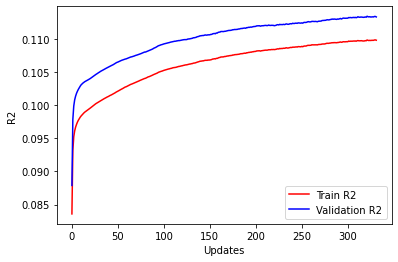

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 501
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

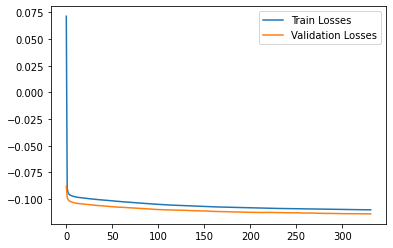

Max Val R2: 0.11341077882957296
Test R2: 0.11090207324053025


In [22]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

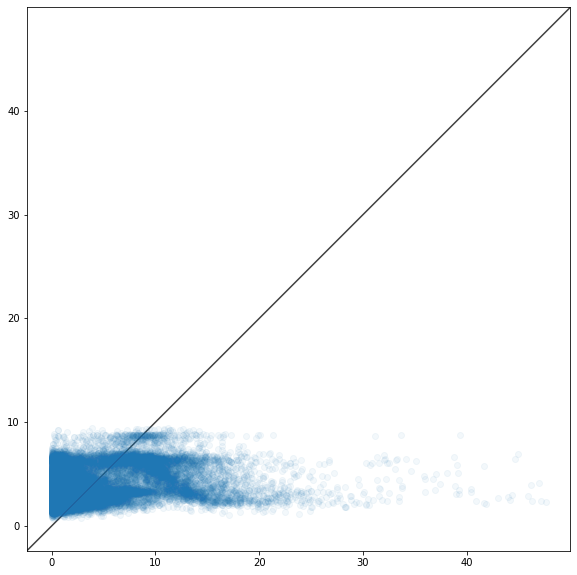

In [23]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## No zones but degree

In [10]:
df = df_full.iloc[:,:11]
df.drop(columns = ['index','hour_index'], inplace = True)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0
...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0


In [11]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [14]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(9,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 865


Epoch  1: Train Loss -0.029946 , Valid Loss -0.095389 ,Train R2 0.091522, Valid R2 0.094964
Epoch 11: Train Loss -0.101923 , Valid Loss -0.106774 ,Train R2 0.102392, Valid R2 0.105984
Epoch 21: Train Loss -0.103895 , Valid Loss -0.108189 ,Train R2 0.104140, Valid R2 0.107442
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss -0.104845 , Valid Loss -0.108723 ,Train R2 0.104822, Valid R2 0.107962
Epoch 41: Train Loss -0.105317 , Valid Loss -0.109004 ,Train R2 0.105243, Valid R2 0.108237
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss -0.105671 , Valid Loss -0.109202 ,Train R2 0.105403, Valid R2 0.108445
Epoch 61: Train Loss -0.105972 , Valid Loss -0.109469 ,Train R2 0.105648, Valid R2 0.108734
Epoch 71: Train Loss -0.106294 , Valid Loss -0.109581 ,Train R2 0.105939, Valid R2 0.108884
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 80: Train Loss -0.106581 , Valid Loss -0.109456 , Train R2 0.106012, Valid R2 0.108791


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

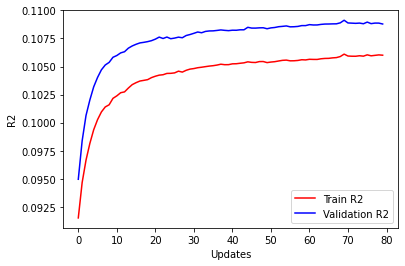

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 501
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

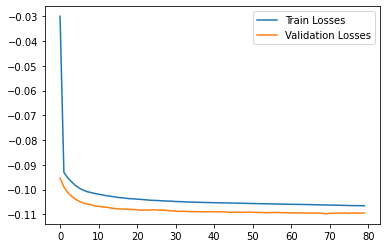

Max Val R2: 0.10912521840060918
Test R2: 0.11037839489590817


In [16]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

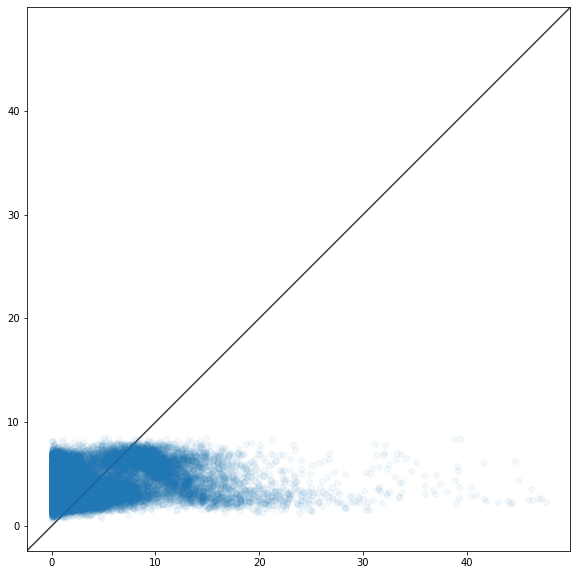

In [17]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Embedding

In [81]:
df = df_full.drop(columns=['dist_to_station', 'degree', 'index', 'hour_index']+weather_var, inplace = False)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone
0,0.38,1,0.999999,0.001309,0,0,1,0,62
1,0.38,1,0.999994,0.003418,1,0,0,0,138
2,0.32,1,0.999984,0.005600,0,1,0,0,95
3,0.65,1,0.999982,0.006036,0,0,1,0,113
4,0.38,1,0.999950,0.010035,0,0,1,0,14
...,...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0,54
155841,0.50,0,0.990258,-0.139245,0,0,1,0,250
155842,0.80,0,0.990629,-0.136580,0,0,1,0,183
155843,0.90,0,0.990797,-0.135355,0,0,1,0,249


In [82]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [8]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(256,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(8+emb_dim,32),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(32,16),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 4)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(256, 4)
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 1985


In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 301
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

Epoch  1: Train Loss 0.109082 , Valid Loss -0.072920 ,Train R2 0.069663, Valid R2 0.071760


KeyboardInterrupt: 

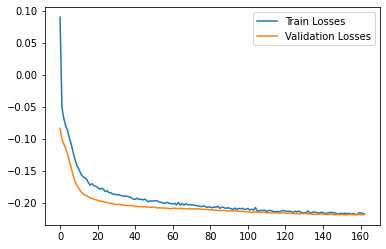

Max Val R2: 0.21953854884530166
Test R2: 0.21927585150347517


In [85]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

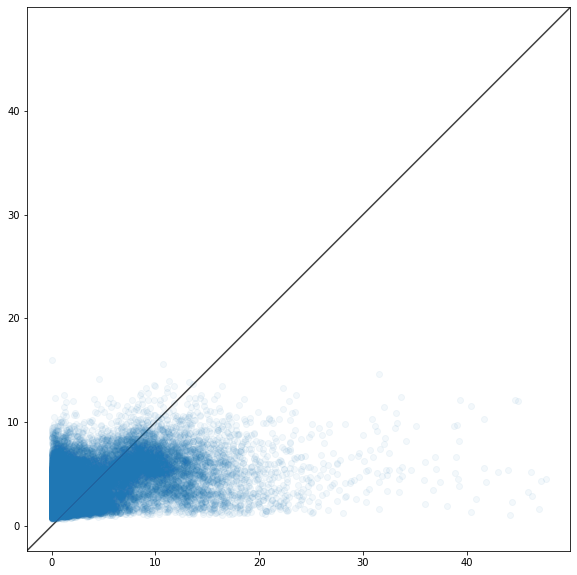

In [86]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Degree

In [87]:
df = df_full.drop(columns=['dist_to_station', 'index', 'hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [88]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

# Normalize according to train
max_train_degree = train_data['degree'].max()
train_data['degree'] = (train_data['degree']-1)/(max_train_degree-1)
val_data['degree'] = (val_data['degree']-1)/(max_train_degree-1)
test_data['degree'] = (test_data['degree']-1)/(max_train_degree-1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [89]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,32),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(32,16),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9057


Epoch  1: Train Loss 0.136629 , Valid Loss -0.123146 ,Train R2 0.119948, Valid R2 0.122513
Epoch 11: Train Loss -0.211252 , Valid Loss -0.235777 ,Train R2 0.245519, Valid R2 0.235806
Epoch 21: Train Loss -0.227091 , Valid Loss -0.240082 ,Train R2 0.259115, Valid R2 0.240377
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss -0.235149 , Valid Loss -0.241265 ,Train R2 0.267221, Valid R2 0.241746
Epoch 41: Train Loss -0.243919 , Valid Loss -0.242853 ,Train R2 0.274107, Valid R2 0.243599
Epoch 51: Train Loss -0.245901 , Valid Loss -0.242746 ,Train R2 0.277117, Valid R2 0.243507
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 59: Train Loss -0.251771 , Valid Loss -0.243113 , Train R2 0.281117, Valid R2 0.244049


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

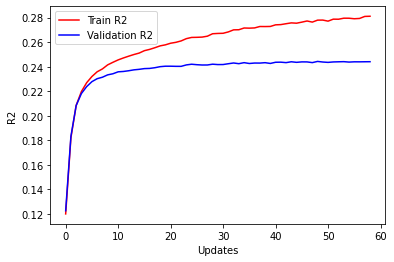

In [90]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

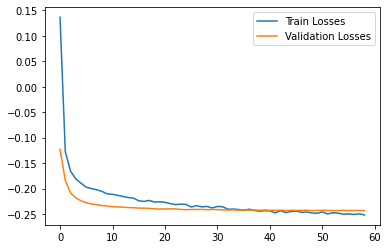

Max Val R2: 0.24428113929037942
Test R2: 0.24104358055689


In [91]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

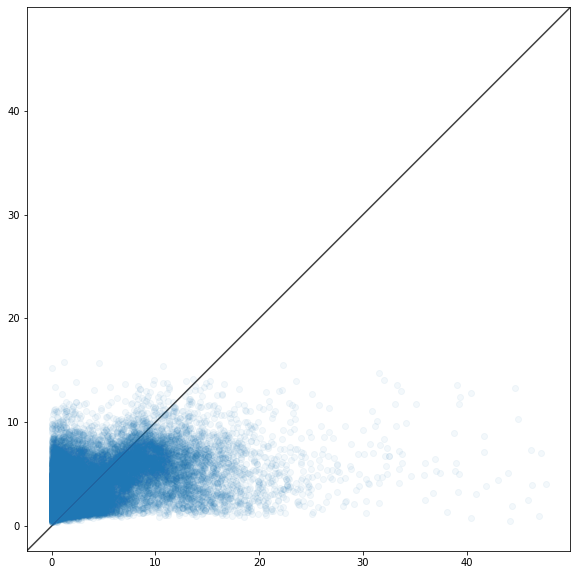

In [92]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Dist to Station

In [93]:
df = df_full.drop(columns=['degree', 'index', 'hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,0.38,1,0.999999,0.001309,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.056678
1,0.38,1,0.999994,0.003418,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.256871
2,0.32,1,0.999984,0.005600,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.100475
3,0.65,1,0.999982,0.006036,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.083079
4,0.38,1,0.999950,0.010035,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.074560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.018069
155841,0.50,0,0.990258,-0.139245,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.160231
155842,0.80,0,0.990629,-0.136580,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.047165
155843,0.90,0,0.990797,-0.135355,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.146090


In [94]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [95]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,32),
            nn.ReLU(),#
            nn.Dropout(0.2),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9057


Epoch  1: Train Loss 0.105320 , Valid Loss -0.139114 ,Train R2 0.136975, Valid R2 0.138416
Epoch 11: Train Loss -0.185259 , Valid Loss -0.210309 ,Train R2 0.220220, Valid R2 0.210861
Epoch 21: Train Loss -0.200857 , Valid Loss -0.213724 ,Train R2 0.230559, Valid R2 0.214269
Epoch 31: Train Loss -0.207947 , Valid Loss -0.215967 ,Train R2 0.236835, Valid R2 0.216571
Epoch 41: Train Loss -0.216057 , Valid Loss -0.216670 ,Train R2 0.242168, Valid R2 0.217394
Epoch 51: Train Loss -0.219567 , Valid Loss -0.217463 ,Train R2 0.245317, Valid R2 0.218248
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss -0.221853 , Valid Loss -0.217123 ,Train R2 0.248444, Valid R2 0.217933
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 65: Train Loss -0.221392 , Valid Loss -0.217275 , Train R2 0.248734, Valid R2 0.218113


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

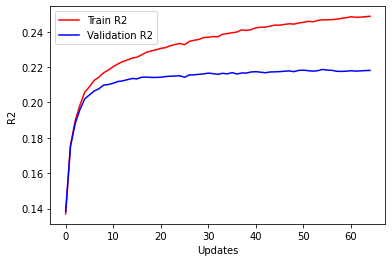

In [96]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

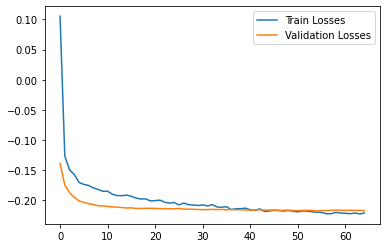

Max Val R2: 0.21863336178912707
Test R2: 0.21781284963826275


In [97]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

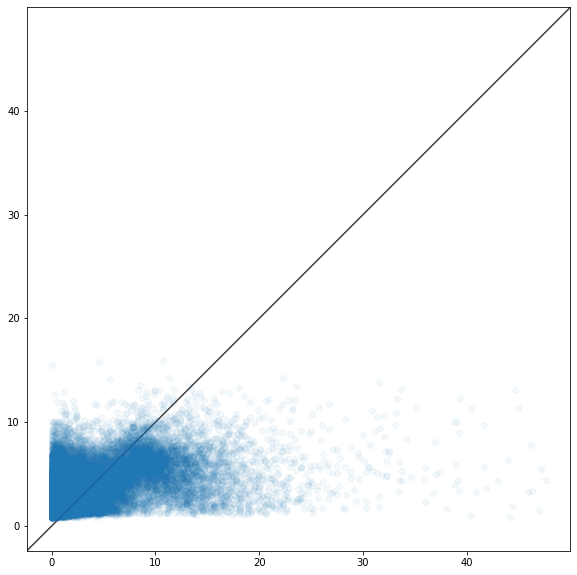

In [98]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Both

In [99]:
df = df_full.drop(columns=['index','hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.056678
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.256871
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.100475
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.083079
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.074560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.018069
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.160231
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.047165
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.146090


In [100]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

# Normalize according to train
max_train_degree = train_data['degree'].max()
train_data['degree'] = (train_data['degree']-1)/(max_train_degree-1)
val_data['degree'] = (val_data['degree']-1)/(max_train_degree-1)
test_data['degree'] = (test_data['degree']-1)/(max_train_degree-1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [101]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(266,32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=266, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9089


Epoch  1: Train Loss 0.067569 , Valid Loss -0.142846 ,Train R2 0.141372, Valid R2 0.142126
Epoch 11: Train Loss -0.219231 , Valid Loss -0.237026 ,Train R2 0.249254, Valid R2 0.237085
Epoch 21: Train Loss -0.233127 , Valid Loss -0.240941 ,Train R2 0.263278, Valid R2 0.241181
Epoch 31: Train Loss -0.238756 , Valid Loss -0.242093 ,Train R2 0.270120, Valid R2 0.242676
Epoch 41: Train Loss -0.245212 , Valid Loss -0.242655 ,Train R2 0.274505, Valid R2 0.243166
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss -0.251375 , Valid Loss -0.242550 ,Train R2 0.279565, Valid R2 0.243323
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 53: Train Loss -0.253297 , Valid Loss -0.242330 , Train R2 0.280319, Valid R2 0.243146


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

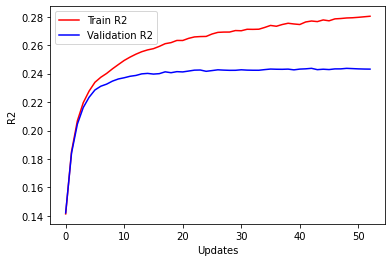

In [102]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

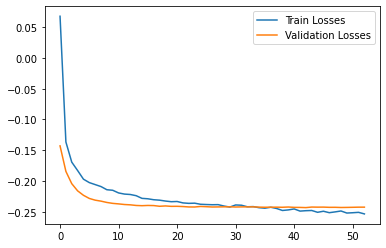

Max Val R2: 0.24370700160606573
Test R2: 0.24012474495788494


In [103]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

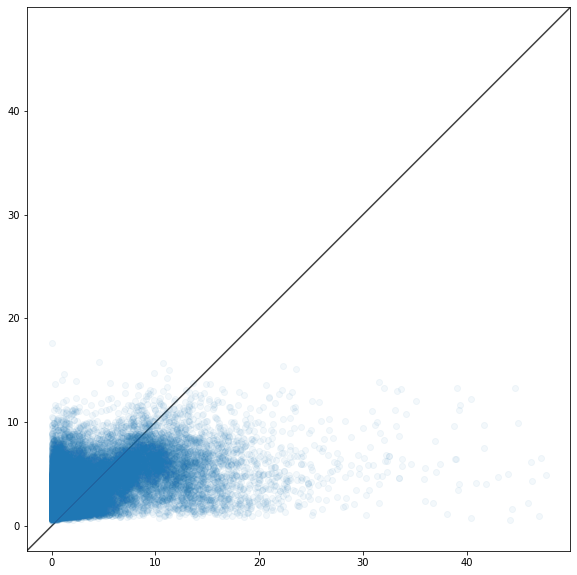

In [104]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Weather

In [4]:
df = df_full.drop(['hour_index', 'time'],axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5000
df

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,6.0,3.4,0.0,0.0,1027.7,72.1,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,6.0,3.4,0.0,0.0,1027.7,72.1,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,6.0,3.4,0.0,0.0,1027.7,72.1,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,6.0,3.4,0.0,0.0,1027.7,72.1,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,6.0,3.4,0.0,0.0,1027.7,72.1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155837,0.59,0,0.999614,-0.027776,10.9,4.9,0.0,0.0,1006.1,89.6,...,0,0,0,0,0,0,0,0,0,0
155838,0.50,0,0.999678,-0.025377,10.9,4.9,0.0,0.0,1006.1,89.6,...,0,0,0,0,0,0,0,0,0,0
155839,0.27,0,0.999731,-0.023196,10.9,4.9,0.0,0.0,1006.1,89.6,...,0,0,0,0,0,0,0,0,0,0
155840,0.58,0,0.999812,-0.019416,10.9,4.9,0.0,0.0,1006.1,89.6,...,0,0,0,0,0,0,0,0,0,0


In [37]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

train_data['degree'] = (train_data['degree'])/50
val_data['degree'] = (val_data['degree'])/50
test_data['degree'] = (test_data['degree'])/50

minmax = True
if minmax:
    val_data = pd.concat([val_data.drop(columns = weather_var), (val_data[weather_var]-train_data[weather_var].min())/(train_data[weather_var].max()-train_data[weather_var].min())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var), (test_data[weather_var]-train_data[weather_var].min())/(train_data[weather_var].max()-train_data[weather_var].min())], axis = 1)
    train_data = pd.concat([train_data.drop(columns = weather_var), (train_data[weather_var]-train_data[weather_var].min())/(train_data[weather_var].max()-train_data[weather_var].min())], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var), (train_data[weather_var]-train_data[weather_var].mean())/(train_data[weather_var].std())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var), (val_data[weather_var]-val_data[weather_var].mean())/(val_data[weather_var].std())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var), (test_data[weather_var]-test_data[weather_var].mean())/(test_data[weather_var].std())], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [38]:
val_data

,leave_fuel,weekend,Time_Cos,Time_Sin,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,...,lz_185143,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover
89671,0.43,1,-0.158517,0.987356,0.058770,0.347746,0,0,1,0,...,0,0,0,0.200000,0.123711,0.000000,0.000000,0.831081,0.895221,0.00
127778,0.89,1,-0.975869,0.218356,0.073375,0.268715,0,0,1,0,...,0,0,0,0.604082,0.278351,0.000000,0.000000,0.765766,0.715074,0.97
7125,0.60,0,0.985923,-0.167199,0.123121,0.231045,0,0,1,0,...,0,0,0,0.534694,0.226804,0.000000,0.000000,0.441441,0.957721,0.30
104238,0.82,0,0.373325,-0.927701,0.090143,0.242306,1,0,0,0,...,0,0,0,0.563265,0.247423,0.000000,0.001667,0.265766,0.665441,0.07
43022,0.55,1,-0.977753,-0.209761,0.060116,0.080866,0,1,0,0,...,0,0,0,0.742857,0.175258,0.000000,0.135000,0.722973,0.435662,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17736,0.74,0,-0.879476,0.475944,0.172346,0.396486,0,1,0,0,...,0,0,0,0.714286,0.226804,0.164557,0.000000,0.443694,0.966912,0.98
84042,0.98,0,0.994001,-0.109373,0.053681,0.073818,0,0,1,0,...,0,0,0,0.644898,0.515464,0.088608,0.000000,0.637387,0.939338,0.99
68743,0.64,0,-0.783151,0.621831,0.136555,0.202751,0,0,1,0,...,0,0,0,0.457143,0.412371,0.000000,0.971667,0.646396,0.823529,0.09
145826,0.61,0,-0.522002,0.852944,0.175218,0.067315,0,0,1,0,...,0,0,0,0.342857,0.206186,0.000000,0.465000,0.824324,0.920956,0.00


In [39]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(273,32),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9313


Epoch  1: Train Loss 0.054564 , Valid Loss -0.130684 ,Train R2 0.141355, Valid R2 0.132226
Epoch 11: Train Loss -0.221369 , Valid Loss -0.226612 ,Train R2 0.246085, Valid R2 0.228956
Epoch 21: Train Loss -0.238191 , Valid Loss -0.231633 ,Train R2 0.262025, Valid R2 0.234014
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss -0.248408 , Valid Loss -0.233725 ,Train R2 0.272639, Valid R2 0.236010
Epoch 41: Train Loss -0.252833 , Valid Loss -0.234739 ,Train R2 0.279194, Valid R2 0.237071
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 49: Train Loss -0.256820 , Valid Loss -0.234258 , Train R2 0.283077, Valid R2 0.236694


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

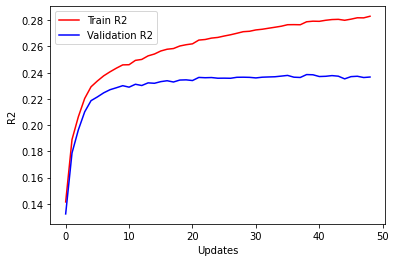

In [40]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

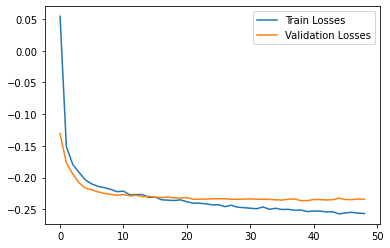

Max Val R2: 0.23856361591484043
Test R2: 0.25218279623868145


In [41]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

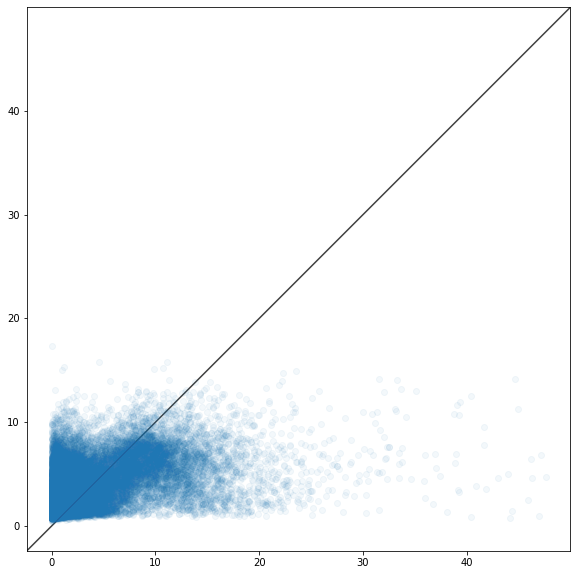

In [46]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Weather and Embedding

In [47]:
df = df_full.drop(columns = ['hour_index', 'index'])
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,Zone
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.056678,62
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.256871,138
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.100475,95
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.083079,113
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.074560,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.018069,54
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.160231,250
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.047165,183
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.146090,249


In [48]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state=2)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

minmax = False
if minmax:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]+['Zone']), (train_data[weather_var[:7]]-train_data[weather_var[:7]].min())/(train_data[weather_var[:7]].max()-train_data[weather_var[:7]].min()),train_data.Zone], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]+['Zone']), (val_data[weather_var[:7]]-val_data[weather_var[:7]].min())/(val_data[weather_var[:7]].max()-val_data[weather_var[:7]].min()),val_data.Zone], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]+['Zone']), (test_data[weather_var[:7]]-test_data[weather_var[:7]].min())/(test_data[weather_var[:7]].max()-test_data[weather_var[:7]].min()),test_data.Zone], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]+['Zone']), (train_data[weather_var[:7]]-train_data[weather_var[:7]].mean())/(train_data[weather_var[:7]].std()),train_data.Zone], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]+['Zone']), (val_data[weather_var[:7]]-val_data[weather_var[:7]].mean())/(val_data[weather_var[:7]].std()),val_data.Zone], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]+['Zone']), (test_data[weather_var[:7]]-test_data[weather_var[:7]].mean())/(test_data[weather_var[:7]].std()),test_data.Zone], axis = 1)
    
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [49]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(256,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(256, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 3425


Epoch  1: Train Loss 0.110953 , Valid Loss -0.072343 ,Train R2 0.071256, Valid R2 0.072199
Epoch 11: Train Loss -0.201257 , Valid Loss -0.212010 ,Train R2 0.219964, Valid R2 0.212326
Epoch 21: Train Loss -0.222529 , Valid Loss -0.227736 ,Train R2 0.239576, Valid R2 0.228425
Epoch 31: Train Loss -0.233483 , Valid Loss -0.233147 ,Train R2 0.248057, Valid R2 0.233727
Epoch 41: Train Loss -0.238938 , Valid Loss -0.237101 ,Train R2 0.254416, Valid R2 0.237778
Epoch 51: Train Loss -0.244506 , Valid Loss -0.240448 ,Train R2 0.260500, Valid R2 0.241158
Epoch 61: Train Loss -0.249064 , Valid Loss -0.241412 ,Train R2 0.265425, Valid R2 0.242127
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss -0.253883 , Valid Loss -0.242161 ,Train R2 0.269015, Valid R2 0.242793
Epoch 81: Train Loss -0.256400 , Valid Loss -0.242108 ,Train R2 0.272293, Valid R2 0.242776
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 91: Train Loss -0.257604 , Valid Loss -0.241969 ,Train R2 0.27

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

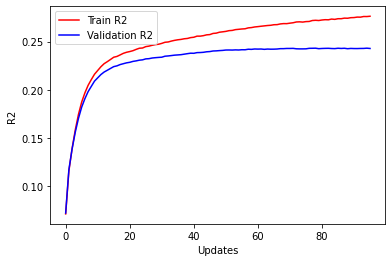

In [50]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

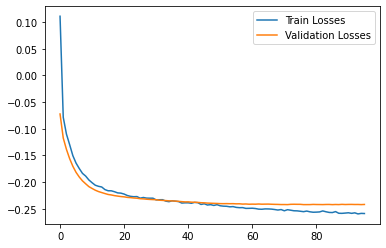

Max Val R2: 0.2430737743121807
Test R2: 0.24201132499058964


In [51]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

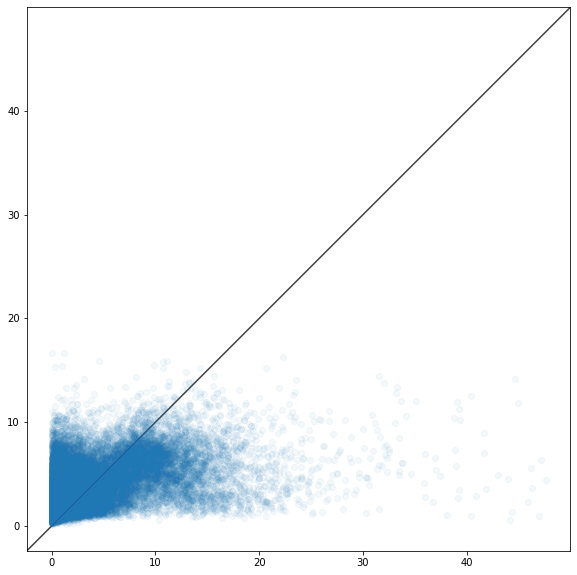

In [52]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Encoded zones

In [53]:
df = df_full.drop(columns=['index', 'hour_index'], inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320

# Zone encoding
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y}).groupby('Zone').mean().squeeze())

df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map({z: v/max(Mean_Zone_Times.values()) for z,v in Mean_Zone_Times.items()})
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,Zone_E
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.056678,0.304134
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.256871,0.316013
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.100475,0.393486
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.083079,0.377995
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.074560,0.141040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.018069,0.450183
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.160231,0.379598
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.047165,0.223921
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.146090,0.434029


In [54]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

minmax = True
if minmax:
    train_data = pd.concat([train_data.drop(columns = weather_var), (train_data[weather_var]-train_data[weather_var].min())/(train_data[weather_var].max()-train_data[weather_var].min())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var), (val_data[weather_var]-val_data[weather_var].min())/(val_data[weather_var].max()-val_data[weather_var].min())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var), (test_data[weather_var]-test_data[weather_var].min())/(test_data[weather_var].max()-test_data[weather_var].min())], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var), (train_data[weather_var]-train_data[weather_var].mean())/(train_data[weather_var].std())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var), (val_data[weather_var]-val_data[weather_var].mean())/(val_data[weather_var].std())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var), (test_data[weather_var]-test_data[weather_var].mean())/(test_data[weather_var].std())], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [55]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(18,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 1153


Epoch  1: Train Loss 0.023913 , Valid Loss -0.119942 ,Train R2 0.114514, Valid R2 0.119630
Epoch 11: Train Loss -0.190020 , Valid Loss -0.209553 ,Train R2 0.207933, Valid R2 0.210444
Epoch 21: Train Loss -0.198742 , Valid Loss -0.213789 ,Train R2 0.212880, Valid R2 0.214631
Epoch 31: Train Loss -0.204189 , Valid Loss -0.215869 ,Train R2 0.216182, Valid R2 0.216760
Epoch 41: Train Loss -0.207634 , Valid Loss -0.217725 ,Train R2 0.218648, Valid R2 0.218597
Epoch 51: Train Loss -0.209868 , Valid Loss -0.218725 ,Train R2 0.220703, Valid R2 0.219493
Epoch 61: Train Loss -0.211943 , Valid Loss -0.219790 ,Train R2 0.222493, Valid R2 0.220711
Epoch 71: Train Loss -0.212364 , Valid Loss -0.221257 ,Train R2 0.223847, Valid R2 0.222085
Epoch 81: Train Loss -0.213684 , Valid Loss -0.222220 ,Train R2 0.225472, Valid R2 0.223093
Epoch 91: Train Loss -0.217214 , Valid Loss -0.223292 ,Train R2 0.226682, Valid R2 0.224168
Epoch 101: Train Loss -0.217872 , Valid Loss -0.224440 ,Train R2 0.228039, Valid 

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

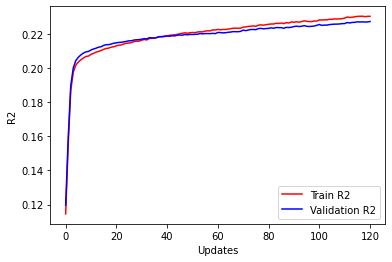

In [56]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

# setting hyperparameters and gettings epoch sizes
batch_size = 512
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

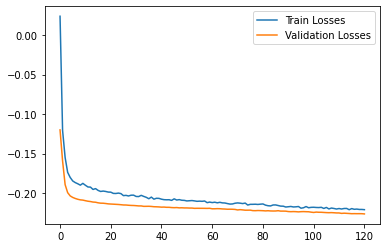

Max Val R2: 0.22712068453145906
Test R2: 0.22704780565394012


In [57]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

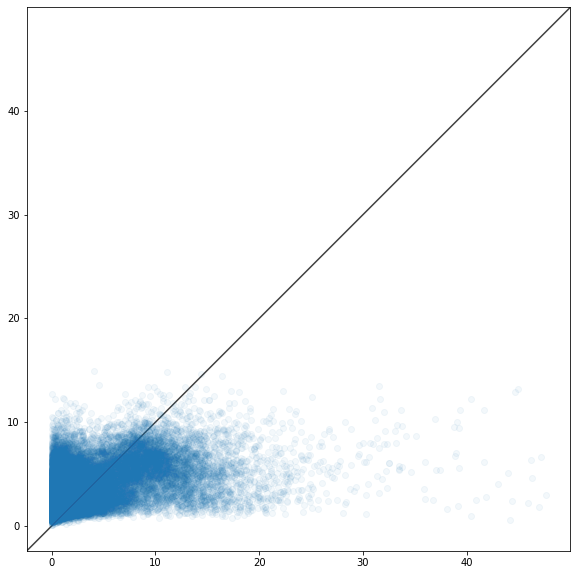

In [58]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0], alpha = 0.05)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## Test env

In [60]:
import sys
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import time

df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)

# Load slicing
with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)
train_idx = np.concatenate(cc[:2])
test_idx = cc[2]

# Set up print
sys.stdout = open("SimpleResults.txt", "w")

def cv(pipe, parameters, X_train, y_train, cf = 4):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring='r2', 
        n_jobs=-4,
        return_train_score=True,
        verbose=2, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

# For classification
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[cc[0]],y[cc[0]]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],y[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))
df_full.drop(columns=['time_to_reservation', 'hour_index', 'time'], inplace=True)

In [51]:
# Normalization
df_full['leave_fuel'] = df_full['leave_fuel']/100
df_full['degree'] = df_full['degree']/50
df_full['dist_to_station'] = df_full['dist_to_station']/5000
df_full[Weather_Scale.index] = (df_full[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']

In [53]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + weather_var + ['dist_to_station'])
df

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.86,0,1.000000,0.000800,0.360118,0,1,0,0
1,0.84,0,0.999989,0.004654,0.197445,0,0,1,0
2,0.99,0,0.999986,0.005381,0.282942,0,0,0,1
3,0.52,0,0.999958,0.009163,0.046701,0,1,0,0
4,0.47,0,0.999880,0.015489,0.353928,0,1,0,0
...,...,...,...,...,...,...,...,...,...
155837,0.59,0,0.999614,-0.027776,0.215514,1,0,0,0
155838,0.50,0,0.999678,-0.025377,0.140707,0,1,0,0
155839,0.27,0,0.999731,-0.023196,0.213340,0,0,1,0
155840,0.58,0,0.999812,-0.019416,0.089864,0,0,1,0


In [61]:
X_train = df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = df.iloc[test_idx]
y_test = y.iloc[test_idx]

In [67]:
import sys
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import time

df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)

# Load slicing
with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)
train_idx = np.concatenate(cc[:2])
test_idx = cc[2]

# Set up print
sys.stdout = open("SimpleResults.txt", "w")

def cv(pipe, parameters, X_train, y_train, cf = 4):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring='r2', 
        n_jobs=-4,
        return_train_score=True,
        verbose=2, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

# For classification
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[cc[0]],y[cc[0]]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],y[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))
df_full.drop(columns=['time_to_reservation', 'hour_index', 'time'], inplace=True)

# Normalization
df_full['leave_fuel'] = df_full['leave_fuel']/100
df_full['degree'] = df_full['degree']/50
df_full['dist_to_station'] = df_full['dist_to_station']/5000
df_full[weather_var] = (df_full[weather_var] - Weather_Scale['Min'])/Weather_Scale['diff']

# Function for scores
def score_model(model, X_train, X_test, y_train, y_test, df_clas = df_clas):
    preds = model.predict(X_test)
    print('')
    print(model.estimator)
    print(f'R2 of training: {r2_score(y_train,model.predict(X_train))}')
    print(f'R2 of test: {r2_score(y_test,preds)}')
    print('----------------------------------------------')
    df_clas['Preds'] = preds
    print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over'], zero_division = 0))
    print('')

time_start = time.time()

##################################
### NO ZONES
##################################
print('----------------------------------------------')
print('---NO ZONES')
print('----------------------------------------------')

# Prep data
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + weather_var + ['dist_to_station'])
X_train = df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = df.iloc[test_idx]
y_test = y.iloc[test_idx]

### LM Model
LM_model = LinearRegression(fit_intercept = True)

parameters = {}

LM_cv = cv(LM_model, parameters, X_train, y_train, cf = 5)

score_model(LM_cv, X_train, X_test, y_train, y_test)

### Elastic Net Model
elastic_net_model = ElasticNet(fit_intercept = True)

parameters = {
    'alpha': np.logspace(-3,-0.5,10),
    'l1_ratio': [0.001,0.01,0.1,0.5,0.9,1]
}

elastic_net_cv = cv(elastic_net_model, parameters, X_train, y_train, cf = 5)

In [76]:
elastic_net_model

ElasticNet()

In [79]:
df = df_full.copy()
X_train = df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = df.iloc[test_idx]
y_test = y.iloc[test_idx]
df

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.86,0,1.000000,0.000800,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
1,0.84,0,0.999989,0.004654,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
2,0.99,0,0.999986,0.005381,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
3,0.52,0,0.999958,0.009163,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,0
4,0.47,0,0.999880,0.015489,0.196347,0.311927,0.0,0.0,0.829885,0.526957,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155837,0.59,0,0.999614,-0.027776,0.420091,0.449541,0.0,0.0,0.333333,0.831304,...,0,0,0,0,0,0,0,0,0,0
155838,0.50,0,0.999678,-0.025377,0.420091,0.449541,0.0,0.0,0.333333,0.831304,...,0,0,0,0,0,0,0,0,0,0
155839,0.27,0,0.999731,-0.023196,0.420091,0.449541,0.0,0.0,0.333333,0.831304,...,0,0,0,0,0,0,0,0,0,0
155840,0.58,0,0.999812,-0.019416,0.420091,0.449541,0.0,0.0,0.333333,0.831304,...,0,0,0,0,0,0,0,0,0,0


In [81]:
Mean_Zone_Times = dict(pd.DataFrame({'Zone': X_train.filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y_train.values}).groupby('Zone').mean().squeeze())

X_train['Zone_E'] = X_train.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
X_test['Zone_E'] = X_test.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
X_train.drop(columns = X_train.filter(regex = 'lz'), inplace = True)
X_test.drop(columns =  X_test.filter(regex = 'lz'), inplace = True)

In [82]:
X_train

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,Zone_E
591,0.30,0,-0.796662,0.604425,0.246575,0.311927,0.0,0.076667,0.788506,0.735652,...,0,0,0,0,0,0,0,0,0,2.399648
146,0.88,0,-0.075051,0.997180,0.182648,0.284404,0.0,0.000000,0.793103,0.777391,...,0,0,0,0,0,0,0,0,1,3.685076
697,0.65,0,-0.903803,0.427949,0.246575,0.311927,0.0,0.076667,0.788506,0.735652,...,0,0,0,0,0,0,0,0,0,2.794951
2135,0.91,0,0.304795,-0.952418,0.191781,0.155963,0.0,0.000000,0.760920,0.721739,...,0,0,0,0,0,0,0,0,0,2.465982
8,0.17,0,0.999104,0.042312,0.196347,0.311927,0.0,0.000000,0.829885,0.526957,...,0,0,0,0,0,0,0,0,0,3.166844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154841,0.74,0,-0.327630,-0.944806,0.543379,0.486239,0.0,0.360000,0.294253,0.504348,...,0,0,0,0,0,0,0,0,0,4.263556
155159,0.89,0,0.130454,-0.991454,0.497717,0.467890,0.0,0.043333,0.298851,0.549565,...,0,0,0,0,0,0,0,0,0,3.167829
153860,0.22,0,-0.631014,0.775771,0.333333,0.302752,0.0,0.781667,0.225287,0.885217,...,0,0,0,0,0,0,0,0,0,4.764669
154581,0.93,0,-0.715693,-0.698415,0.570776,0.477064,0.0,0.475000,0.282759,0.403478,...,0,0,0,0,0,0,0,0,0,2.399648
